In [ ]:
# Data gathered on: https://www.jodidata.org/oil/database/data-downloads.aspx -> extended csv - secondary -> NewProcedure_Secondary_CSV
# For complimentary information check: https://www.jodidata.org/_resources/files/downloads/oil-data/jodi-oil-wdb-item-names-ver2017.pdf

# Importing the packages used

In [2]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os

#Acesso ao Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data wrangling 1

In [3]:
# 1. dataset loading
path_new_procedure = '/content/drive/MyDrive/Case/NewProcedure_Secondary_CSV.csv'
df = pd.read_csv(path_new_procedure, sep=';', header=0)

# removing inconvenient spaces before and after column names
df.columns = df.columns.str.strip()

# 2. Filtering the inicial dataset
df_filtered = df[
    (df['ASSESSMENT_CODE'] == 1) & # Assessed data within reasonable levels of comparability
    (df['UNIT_MEASURE'] == 'KBBL') & # will model only in KBBL
    (df['ENERGY_PRODUCT'].isin(['GASOLINE', 'GASDIES'])) &
    (df['REF_AREA'] == 'AU') # will focus on Diesel and Gasoline
].copy().drop(columns=['ASSESSMENT_CODE', 'UNIT_MEASURE'])

# 3. Pre-processing
# formating data
df_filtered['TIME_PERIOD'] = pd.to_datetime(df_filtered['TIME_PERIOD'])

# dealing with inconvinient values and coercing them to the average value of the series
df_filtered['OBS_VALUE'] = df_filtered['OBS_VALUE'].str.replace('.', '', regex=False)
df_filtered['OBS_VALUE'] = df_filtered['OBS_VALUE'].replace('x', np.nan)
df_filtered['OBS_VALUE'] = pd.to_numeric(df_filtered['OBS_VALUE'])

# making sure that every transformation is being applied to the right place
group_cols = ['REF_AREA', 'ENERGY_PRODUCT', 'FLOW_BREAKDOWN']
df_filtered['OBS_VALUE'] = df_filtered.groupby(group_cols)['OBS_VALUE'].transform(lambda x: x.fillna(x.mean()))

# dividing between gasoline and diesel
df_gasoline = df_filtered[df_filtered['ENERGY_PRODUCT'] == "GASOLINE"]
df_diesel = df_filtered[df_filtered['ENERGY_PRODUCT'] == "GASDIES"]

# 4. Pivoting the dataframe to match the required format to model
df_gasoline = df_gasoline.pivot_table(
    index='TIME_PERIOD',
    columns='FLOW_BREAKDOWN',
    values='OBS_VALUE',
    #aggfunc='mean'
).reset_index().drop(columns=['IPTRANSF', 'PTRANSF', 'RECEIPTS'])

df_diesel = df_diesel.pivot_table(
    index='TIME_PERIOD',
    columns='FLOW_BREAKDOWN',
    values='OBS_VALUE',
    #aggfunc='mean'
).reset_index().drop(columns=['IPTRANSF', 'PTRANSF', 'RECEIPTS'])

# guaranteeing that the target is in the last column
# gasoline
target_column = 'TOTDEMO'
variable_columns = [col for col in df_gasoline.columns if col != target_column]
variable_columns.append(target_column)
df_gasoline = df_gasoline[variable_columns]
df_gasoline['TOTEXPSB'] = df_gasoline['TOTEXPSB'].transform(lambda x: x.fillna(x.mean()))

# diesel
variable_columns = [col for col in df_diesel.columns if col != target_column]
variable_columns.append(target_column)
df_diesel = df_diesel[variable_columns]
df_diesel['TOTEXPSB'] = df_diesel['TOTEXPSB'].transform(lambda x: x.fillna(x.mean()))


#df_filtered['FLOW_BREAKDOWN'].unique()
#df_gasoline.columns
df_diesel.columns

# AT = Australia
# AU = Austria
# AR = Argentina
# BB = Barbados

Index(['TIME_PERIOD', 'CLOSTLV', 'REFGROUT', 'STOCKCH', 'TOTEXPSB', 'TOTIMPSB',
       'TOTDEMO'],
      dtype='object', name='FLOW_BREAKDOWN')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 377
[LightGBM] [Info] Number of data points in the train set: 267, number of used features: 5
[LightGBM] [Info] Start training from score 118187913.947566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

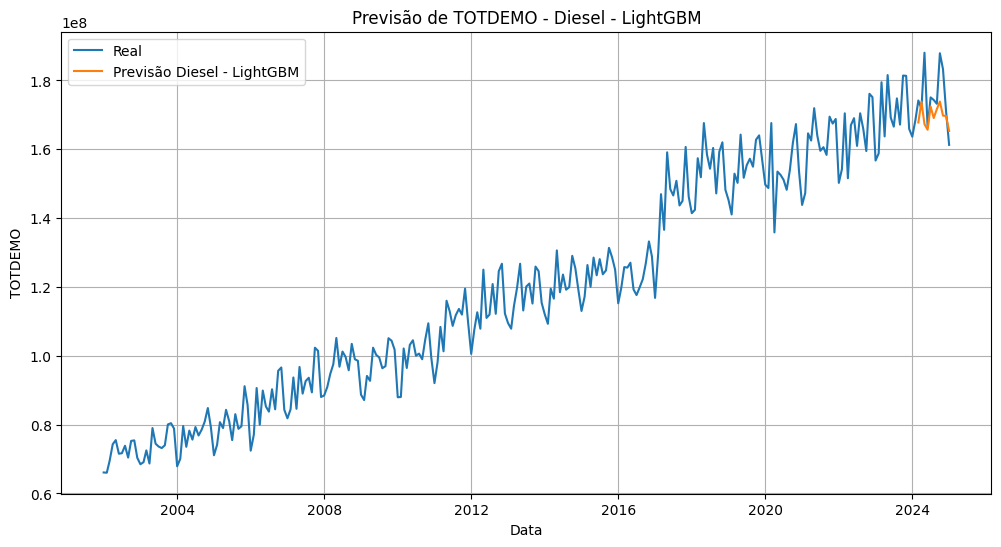

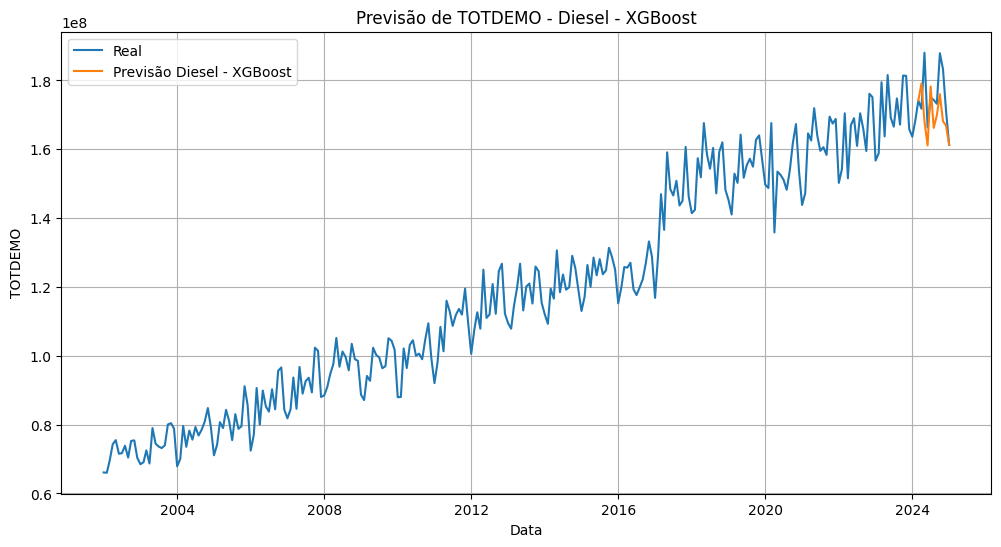

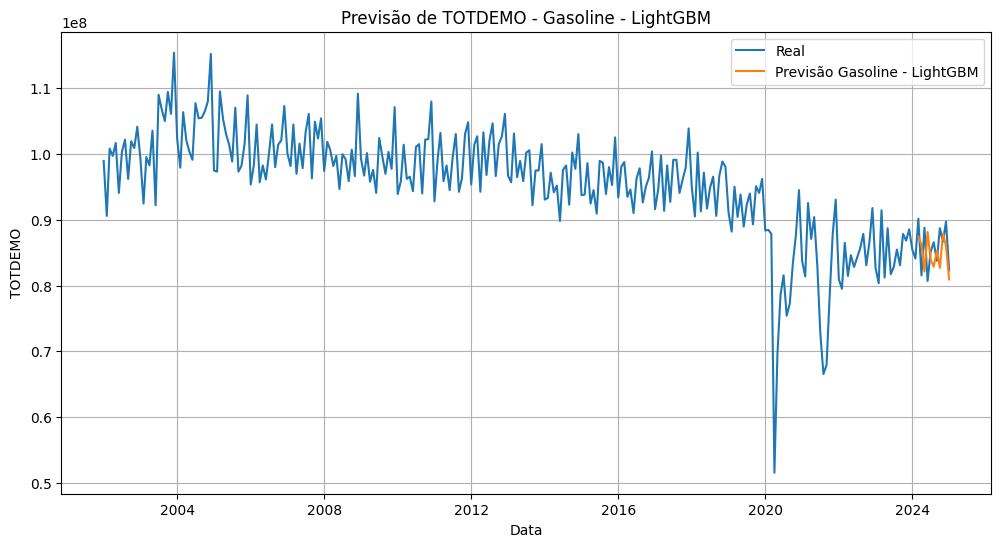

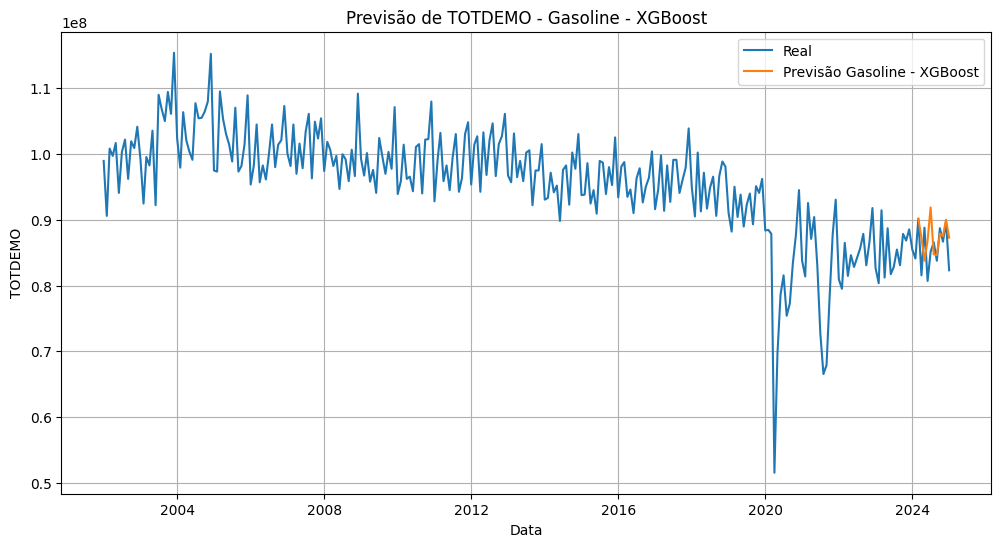

In [4]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Preparar os dados
def prepare_data(df):
    X = df.drop(columns=['TOTDEMO', 'TIME_PERIOD'])
    y = df['TOTDEMO']
    dates = pd.to_datetime(df['TIME_PERIOD'])
    return X, y, dates

# Treinar e prever
def train_and_forecast(X, y, dates, model_type='lightgbm'):
    cutoff_date = pd.Timestamp('2024-03-01')

    train_idx = dates <= cutoff_date
    X_train = X[train_idx]
    y_train = y[train_idx]

    test_idx = (dates >= cutoff_date) & (dates < cutoff_date + pd.DateOffset(months=12))
    X_test = X[test_idx]
    y_test = y[test_idx]
    dates_test = dates[test_idx]

    if model_type == 'lightgbm':
        model = LGBMRegressor()
    elif model_type == 'xgboost':
        model = XGBRegressor()
    else:
        raise ValueError("model_type deve ser 'lightgbm' ou 'xgboost'")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f"=== Métricas para {model_type.upper()} ===")
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print()

    # feature importance
    if hasattr(model, 'feature_importances_'):
        importance = pd.DataFrame({
            'Feature': X.columns,
            'Importance': model.feature_importances_
        }).sort_values(by='Importance', ascending=False)

        print("=== Feature Importance ===")
        print(importance)
        print()

    # Forecast dataframe
    forecast_df = pd.DataFrame({
        'TIME_PERIOD': dates_test,
        'Forecast_TOTDEMO': y_pred,
        'Real_TOTDEMO': y_test.values
    })

    return model, forecast_df

# forecast plot
def plot_forecasts(dates, y_true, forecast_df, label):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_true, label='Real')
    plt.plot(forecast_df['TIME_PERIOD'], forecast_df['Forecast_TOTDEMO'], label=f'Previsão {label}')
    plt.legend()
    plt.title(f'Previsão de TOTDEMO - {label}')
    plt.xlabel('Data')
    plt.ylabel('TOTDEMO')
    plt.grid()
    plt.show()


# Diesel
X_diesel, y_diesel, dates_diesel = prepare_data(df_diesel)
model_lgbm_diesel, forecast_lgbm_diesel = train_and_forecast(X_diesel, y_diesel, dates_diesel, model_type='lightgbm')
model_xgb_diesel, forecast_xgb_diesel = train_and_forecast(X_diesel, y_diesel, dates_diesel, model_type='xgboost')

# Gasolina
X_gasoline, y_gasoline, dates_gasoline = prepare_data(df_gasoline)
model_lgbm_gasoline, forecast_lgbm_gasoline = train_and_forecast(X_gasoline, y_gasoline, dates_gasoline, model_type='lightgbm')
model_xgb_gasoline, forecast_xgb_gasoline = train_and_forecast(X_gasoline, y_gasoline, dates_gasoline, model_type='xgboost')

# forecast
# Diesel
plot_forecasts(dates_diesel, y_diesel, forecast_lgbm_diesel, label='Diesel - LightGBM')
plot_forecasts(dates_diesel, y_diesel, forecast_xgb_diesel, label='Diesel - XGBoost')

# Gasoline
plot_forecasts(dates_gasoline, y_gasoline, forecast_lgbm_gasoline, label='Gasoline - LightGBM')
plot_forecasts(dates_gasoline, y_gasoline, forecast_xgb_gasoline, label='Gasoline - XGBoost')

In [ ]:
!pip install prophet

# Prophet

In [5]:
#Prophet
import prophet
from prophet.plot import add_changepoints_to_plot
from datetime import datetime, timedelta

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_vgtv2mj/lfnh9qfp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_vgtv2mj/kvahab6e.json
22:04:21 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=95944', 'data', 'file=/tmp/tmp_vgtv2mj/lfnh9qfp.json', 'init=/tmp/tmp_vgtv2mj/kvahab6e.json', 'output', 'file=/tmp/tmp_vgtv2mj/prophet_modelvi6albf7/prophet_model-20250409220421_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=95944', 'data', 'file=/tmp/tmp_vgtv2mj/lfnh9qfp.json', 'init=/tmp/tmp_vgtv2mj/kvahab6e.json', 'output', 'file=/tmp/tmp_vgtv2mj/prophet_modelvi6albf7/prophet_model-20250409220421_2.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanp

22:04:32 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=95944', 'data', 'file=/tmp/tmp_vgtv2mj/lfnh9qfp.json', 'init=/tmp/tmp_vgtv2mj/kvahab6e.json', 'output', 'file=/tmp/tmp_vgtv2mj/prophet_modelvi6albf7/prophet_model-20250409220421_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp_vgtv2mj/prophet_modelvi6albf7/prophet_model-20250409220421_1.csv
 console_msgs (if any):
	/tmp/tmp_vgtv2mj/prophet_modelvi6albf7/prophet_model-20250409220421_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 50
    num_warmup = 50
    save_warmup = 0 (Default)
    thin = 1 (Default)


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


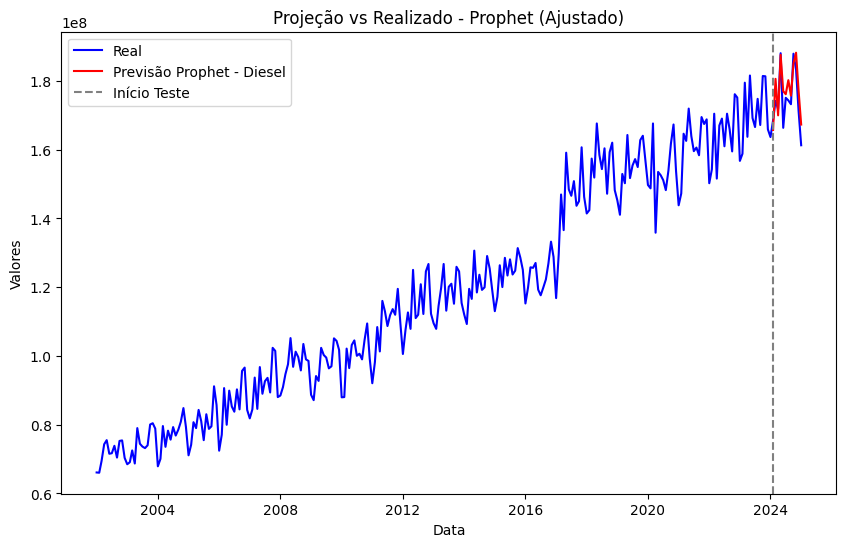

In [6]:
# Creating the empty dataframe
df_result = pd.DataFrame({'ds': dates_diesel, 'y': y_diesel})
df_result

# 2. Defining the division (Hold-out).
train_size = int(len(df_result)-12)
train = df_result.iloc[:train_size]
test = df_result.iloc[train_size:]

# Ajuste dos parâmetros do Prophet para crescimento mais lento e melhor ajuste
model = prophet.Prophet(
    growth='linear',  # Defining growth rate as lineaar (default is 'logistic')
    seasonality_mode='multiplicative', # Define a sazonalidade como multiplicativa, podendo melhorar o ajuste em dados com sazonalidade não linear.
    seasonality_prior_scale=0.1,  # Redução da influência da sazonalidade para um crescimento menos volátil
    holidays_prior_scale=0.05, # menor influência dos feriados
    changepoint_prior_scale=0.01, # menor influência dos changepoints
    mcmc_samples=100
)
model.fit(train)

# Criando a previsão para o período de teste
future = model.make_future_dataframe(periods=len(test), freq='M')
forecast_prophet = model.predict(future)

# Plotando apenas as predições
plt.figure(figsize=(10, 6))
plt.plot(df_result['ds'], df_result['y'], label='Real', color='blue')
plt.plot(test['ds'], forecast_prophet['yhat'][train_size:], label='Previsão Prophet - Diesel', color='red')
plt.axvline(x=test['ds'].min(), color='gray', linestyle='--', label='Início Teste')
plt.legend()
plt.xlabel('Data')
plt.ylabel('Valores')
plt.title('Projeção vs Realizado - Prophet (Ajustado)')
plt.show()

forecast_prophet['ds'] = forecast_prophet['ds'].apply(lambda d: d.replace(day=1))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_vgtv2mj/gu5pvpbh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_vgtv2mj/mvr3b1ia.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1365', 'data', 'file=/tmp/tmp_vgtv2mj/gu5pvpbh.json', 'init=/tmp/tmp_vgtv2mj/mvr3b1ia.json', 'output', 'file=/tmp/tmp_vgtv2mj/prophet_modelihmv1sng/prophet_model-20250409220432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:04:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:04:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prop

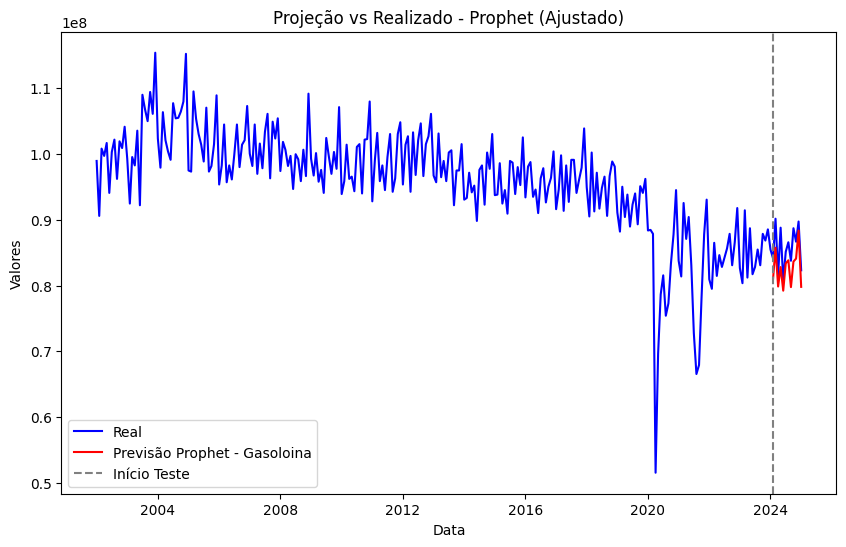

In [7]:
# Criando o DataFrame
df_result = pd.DataFrame({'ds': dates_gasoline, 'y': y_gasoline })
df_result

# 2. Definindo a divisão (Hold-out).
train_size = int(len(df_result)-12)
train = df_result.iloc[:train_size]
test = df_result.iloc[train_size:]

# Ajuste dos parâmetros do Prophet para crescimento mais lento e melhor ajuste
model = prophet.Prophet(
    growth='linear',  # Define o crescimento como linear (padrão é 'logistic')
    seasonality_mode='multiplicative', # Define a sazonalidade como multiplicativa, podendo melhorar o ajuste em dados com sazonalidade não linear.
    seasonality_prior_scale=0.1,  # Redução da influência da sazonalidade para um crescimento menos volátil
    holidays_prior_scale=0.05, # menor influência dos feriados
    changepoint_prior_scale=0.01 # menor influência dos changepoints
)
model.fit(train)

# Criando a previsão para o período de teste
future = model.make_future_dataframe(periods=len(test), freq='M')
forecast_prophet2 = model.predict(future)

# Plotando apenas as predições
plt.figure(figsize=(10, 6))
plt.plot(df_result['ds'], df_result['y'], label='Real', color='blue')
plt.plot(test['ds'], forecast_prophet2['yhat'][train_size:], label='Previsão Prophet - Gasoloina', color='red')
plt.axvline(x=test['ds'].min(), color='gray', linestyle='--', label='Início Teste')
plt.legend()
plt.xlabel('Data')
plt.ylabel('Valores')
plt.title('Projeção vs Realizado - Prophet (Ajustado)')
plt.show()


In [8]:
forecast_prophet.to_excel('/content/drive/MyDrive/Case/forecast_prophet.xlsx', index=False)
forecast_prophet2.to_excel('/content/drive/MyDrive/Case/forecast_prophet2.xlsx', index=False)
forecast_lgbm_diesel.to_excel('/content/drive/MyDrive/Case/forecast_lgbm_diesel.xlsx', index=False)
forecast_xgb_diesel.to_excel('/content/drive/MyDrive/Case/forecast_xgb_diesel.xlsx', index=False)
forecast_lgbm_gasoline.to_excel('/content/drive/MyDrive/Case/forecast_lgbm_gasoline.xlsx', index=False)
forecast_xgb_gasoline.to_excel('/content/drive/MyDrive/Case/forecast_xgb_gasoline.xlsx', index=False)
df_diesel.to_excel('/content/drive/MyDrive/Case/df_diesel.xlsx', index=False)
df_gasoline.to_excel('/content/drive/MyDrive/Case/df_gasoline.xlsx', index=False)
